# Basic Usage Tutorial

Adam Klie (last updated: *06/23/2023*)

In this tutorial, we illustrate a basic workflow in EUGENe to train a single task regression model on a published dataset of plant promoters. If you are just starting out with EUGENE, you are in the right place! This tutorial will walk you through the steps of preparing the data, training a single task regression model, and interpreting that trained model.

You can also find this tutorial as a Jupyter notebook in the `docs` [directory of the EUGENE repository](https://github.com/cartercompbio/EUGENe/blob/main/docs/basic_usage_tutorial.ipynb). You can copy this notebook or just copy and paste the code into a new notebook to follow along. Just make sure to have [installed EUGENe](https://eugene-tools.readthedocs.io/en/latest/installation.html) in your environment before you start!

> **Warning** 
> Before you start! Running this notebook without a GPU on this data is feasible but will be very slow. We'd recommend using [Google Colab](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) if you don't have access to your own GPU.

> **Note** 
> We've noticed that for some environments, plots do not render in a Jupyter notebook unless you include the `%matplotlib inline` magic command. If you are having trouble rendering plots, make sure you have this line in your notebook or use `plt.show()` after each plot.

## Configuring

In [1]:
import os
import glob
import numpy as np

To make the sometimes painful process of keeping track of global parameters and input/output file paths easier, we usually like to set these through `settings` up front. We can also do things like set the random seed for reproducibility (by default 13), the number of gpus available, the number of workers to use and more!

In [13]:
# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

## Dataloading
For this tutorial, we will reproduce the prediction of promoter activity featured in [Jores et al., 2021](https://www.google.com/search?q=Synthetic+promoter+designs+enabled+by+a+comprehensive+analysis+of+plant+core+promoters.&oq=syn&aqs=chrome.2.69i60j69i57j69i59j0i131i433i512j0i433i512j69i60l3.1354j0j4&sourceid=chrome&ie=UTF-8) that uses DNA sequences as input to predict [STARR-seq activity](https://en.wikipedia.org/wiki/STARR-seq). We first need to load this dataset. If the dataset is a "EUGENe benchmarking dataset", it can be loaded in through the `SeqDatasets` [subpackage](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#datasets-quickly-start-your-development-or-benchmarking).

In [14]:
import seqdatasets

 Use `get_dataset_info()` to get information about the datasets available as "EUGENe benchmarking datasets". 

In [15]:
# Check the dataset
seqdatasets.get_dataset_info()

,n_seqs,n_targets,metadata,url,description,author
dataset_name,,,,,,
random1000,1000,1,10 randomly generated binary labels (label_{0-...,https://github.com/cartercompbio/EUGENe/tree/m...,A randomly generated set of 1000 sequences wit...,Adam Klie (aklie@eng.ucsd.edu)
ray13,241357,244,"probe set (Probe_Set), bidning intensity value...",http://hugheslab.ccbr.utoronto.ca/supplementar...,This dataset represents an in vitro RNA bindin...,Hayden Stites (haydencooperstites@gmail.com)
farley15,163708,2,"barcode (Barcode), RPMs from each biological r...",https://zenodo.org/record/6863861#.YuG15uxKg-Q,This dataset represents SEL-seq data of C. int...,Adam Klie (aklie@eng.ucsd.edu)
deBoer20,100000000+,1,Variable depending on chosen file,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...,Gigantic parallel reporter assay data from ~10...,Adam Klie (aklie@eng.ucsd.edu)
jores21,147966,1,"set (set), species (sp), gene promoter came fr...",https://raw.githubusercontent.com/tobjores/Syn...,"This datast includes activity scores for 79,83...",Adam Klie (aklie@eng.ucsd.edu)
deAlmeida22,484052,4,Normalized enrichment scores for developmental...,https://zenodo.org/record/5502060/,This dataset includes UMI-STARR-seq data from ...,Adam Klie (aklie@eng.ucsd.edu)



We are in luck! The plant promoter dataset is available using the `jores21()` command. If you are requesting this dataset for the for the first time, it will be downloaded and loaded into a `SeqData` object automatically. If you want to learn more about the `SeqData` object, check out the [documentation](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#seqdata).

In [16]:
# Download the dataset to the dataset dir. We are using the promoters assayed in leaf promoters here
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

> **Note**
> You can also read from standard file formats into `SeqData` objects using `read_*()` functions from the `dataload` (`dl`) [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#dataload-read-write-data-from-many-common-file-formats)


Let's also quickly check the annotations we have associated with this dataset. We can do this with by accessing the `seqs_annot` attribute

In [6]:
# Check what annotations we have for this dataset
sdata.seqs_annot

AttributeError: 'Dataset' object has no attribute 'seqs_annot'

## Data Visualization
Data visualization is a key part of the EUGENe workflow. We can use the `plot` (`pl`) module to visualize aspects of our dataset like sequence lengths and target value distributions. This particular dataset isn't terribly exciting, and the target values come pre-normalized, so we encourage users to explore the `pl` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#plot) further.

In [17]:
from eugene import plot as pl

In [18]:
# Plot the distribution of targets across the different species the promoters were derived from
pl.violinplot(
    sdata,
    keys=["enrichment"],
    groupby="sp",
    figsize=(4, 4),
)

## Preprocessing
We can preprocess our data using the `preprocess` (`pp`) module. This module includes several functions for common sequence preprocessing tasks like [one-hot encoding](https://eugene-tools.readthedocs.io/en/latest/api/eugene.pp.ohe_seqs.html#eugene.pp.ohe_seqs) or [reverse complementation](https://eugene-tools.readthedocs.io/en/latest/api/eugene.pp.reverse_complement_seqs.html#eugene.pp.reverse_complement_seqs). We can also use the `pp` module to split our data into training, validation, and test sets. We encourage users to explore the `pp` [module documentation](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#preprocess-prepare-data-for-sequence-based-deep-learning) to see the list of functions available.

### Sequence preprocessing
Here we will one-hot encode our sequences. One-hot encoding is a common way to represent sequences as a matrix of 0s and 1s for model training. Here we pass in DNA as the vocab explicitly, but this is the default if not specified.

In [19]:
from eugene import preprocess as pp

In [20]:
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(
    sdata,
    alphabet="DNA"
)

### Dataset preprocessing
As is standard machine learning practice, we also need to split our data into training, validation, and test sets. This dataset comes with 'train' and 'test' labels in the 'set' annotation, but we also need to split the training sequences into train and validation sets. We can do this using the `train_test_split_sdata` function from the `pp` module that wraps `sklearn`.

In [21]:
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())
sdata_train, sdata_test

(<xarray.Dataset>
 Dimensions:     (_sequence: 65004, _length: 170, length: 170, _ohe: 4)
 Dimensions without coordinates: _sequence, _length, length, _ohe
 Data variables:
     enrichment  (_sequence) float64 dask.array<chunksize=(846,), meta=np.ndarray>
     gene        (_sequence) object dask.array<chunksize=(846,), meta=np.ndarray>
     seq         (_sequence, _length) |S1 dask.array<chunksize=(846, 170), meta=np.ndarray>
     set         (_sequence) object dask.array<chunksize=(846,), meta=np.ndarray>
     sp          (_sequence) object dask.array<chunksize=(846,), meta=np.ndarray>
     ohe_seq     (_sequence, length, _ohe) uint8 0 1 0 0 0 0 1 ... 0 1 0 1 0 0 0,
 <xarray.Dataset>
 Dimensions:     (_sequence: 7154, _length: 170, length: 170, _ohe: 4)
 Dimensions without coordinates: _sequence, _length, length, _ohe
 Data variables:
     enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
     gene        (_sequence) object dask.array<chunksize=(1000,), me

In [22]:
# Split the training set into training and validation
pp.train_test_random_split(
    sdata_train,
    dim="_sequence",
    train_key="train_val",
    test_size=0.2
)

In [24]:
# Check the split with a count plot
pl.countplot(
    sdata_train,
    keys="train_val",
    orient="h"
)

       _sequence  train_val
0              0       True
1              1       True
2              2       True
3              3       True
4              4       True
...          ...        ...
64999      64999       True
65000      65000       True
65001      65001      False
65002      65002       True
65003      65003      False

[65004 rows x 2 columns]


## Training
Now that we have our data ready, it's time to train our model. 

### Instantiation and initialization

We first need to instantiate and initialize our model. We can use the `models` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#models-instantiate-and-initialize-neural-network-architectures) to do this.

We offer several options for instantiating a model architecture. Take a look at the [API](https://eugene-tools.readthedocs.io/en/latest/api.html#models) for more options and details:

Here we will load in a Hybrid architecture that contains convoultional blocks that feed into recurrent layers, finishing with fully connected ones. We have set up a configuration file that trains pretty well on this dataset that you can download from [here](https://github.com/cartercompbio/EUGENe/blob/main/tutorials/tutorial_configs/ssHybrid.yaml).

In [25]:
from eugene import models

In [26]:
!wget https://raw.githubusercontent.com/adamklie/EUGENe_paper/revision/configs/jores21/hybrid.yaml -O ~/tutorial_configs/hybrid.yaml

--2023-06-23 16:50:20--  https://raw.githubusercontent.com/adamklie/EUGENe_paper/revision/configs/jores21/hybrid.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 719 [text/plain]
Saving to: ‘/cellar/users/aklie/tutorial_configs/hybrid.yaml’

/cellar/users/aklie 100%[===================>]     719  --.-KB/s    in 0s      

2023-06-23 16:50:21 (76.2 MB/s) - ‘/cellar/users/aklie/tutorial_configs/hybrid.yaml’ saved [719/719]



In [27]:
model = models.load_config("hybrid.yaml")

In [28]:
# Print out a summary of the model
model.summary()

Model: Hybrid
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params
-----------------------------------------
0 | arch         | Hybrid  | 1.9 M 
1 | train_metric | R2Score | 0     
2 | val_metric   | R2Score | 0     
3 | test_metric  | R2Score | 0     
-----------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)

In [29]:
# Initialize the weights
models.init_weights(model)

### Model fitting

With a model intantiated and initialized, we are set up to fit our model to some data. We can do this through the `train` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#train). 

If you are using GPU accelerators on your machine, you can can use the `gpus` argument to set the number gpus you want to use. If left empty, EUGENe will try to infer the number of GPUs available. Training the model with a single GPU will take less than 5 minutes.

In [30]:
from eugene import train

In [33]:
train.fit_sequence_module(
    model,
    sdata_train,
    seq_key="ohe_seq",
    target_keys=["enrichment"],
    in_memory=True,
    train_key="train_val",
    epochs=25,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="hybrid",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory
No seed set


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | arch         | Hybrid  | 1.9 M 
1 | train_metric | R2Score | 0     
2 | val_metric   | R2Score | 0     
3 | test_metric  | R2Score | 0     
-----------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
eu.train.fit(
    model=model, 
    sdata=sdata_train, 
    gpus=1, 
    target_keys="enrichment",
    train_key="train_val",
    epochs=50,
    batch_size=128,
    num_workers=0,
    seed=13,
    version="tutorial_model"
)

Global seed set to 13


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | hp_metric    | R2Score                   | 0     
1 | convnet      | BasicConv1D               | 1.7 M 
2 | recurrentnet | BasicRecurrent            | 197 K 
3 | fcn          | BasicFullyConnectedModule | 8.4 K 
-----------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 13
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We can see how well our models trained by plotting a training summary. All you need to do is point the [training_summary](https://eugene-tools.readthedocs.io/en/latest/api/eugene.pl.training_summary.html#eugene.pl.training_summary) function to your the EUGENe logging directory.

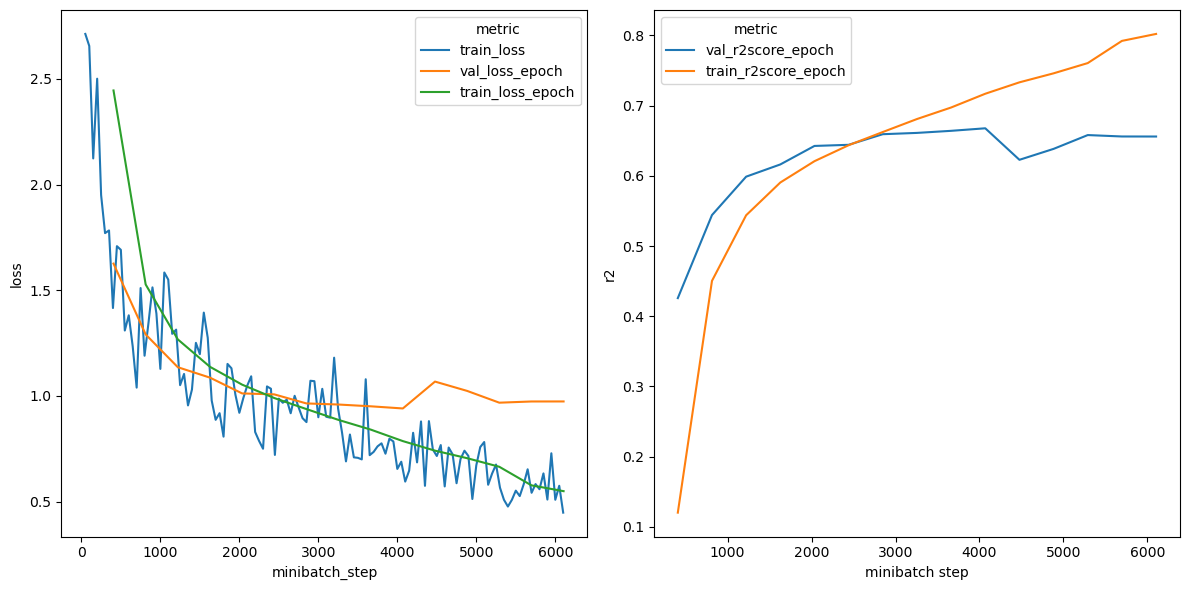

In [36]:
# Plot a loss curve and an r2 curve as a metric
pl.training_summary(
    os.path.join(settings.logging_dir, "hybrid", "tutorial_model"),
    metric="r2"
)

## Evaluation
After the model's been trained, we can evaluate our performance on our held-out test data. This is done through the `evaluate` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#evaluate).

It is often best to use the model that achieved the lowest loss on the validation data for evaluation. We can load this model in from the log directory:

In [41]:
from eugene import evaluate

In [40]:
# We point to the checkpoints directory within the logging directory to grab the best model
model_file = glob.glob(os.path.join(settings.logging_dir, "hybrid", "tutorial_model", "checkpoints", "*"))[0]
best_model = models.SequenceModule.load_from_checkpoint(model_file, arch=model.arch)

And then use it to make predictions on our held out test data.

In [44]:
# Use this best model to predict on the held-out data. This will store predictions in
# the SeqData object and write them to disk by default in eugene.settings.output_dir
evaluate.predictions_sequence_module(
    best_model,
    sdata=sdata_test,
    seq_key="ohe_seq",
    target_keys="enrichment",
    batch_size=2048,
    in_memory=True,
    name="hybrid",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Loading ohe_seq and ['enrichment'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve perf

Predicting: 0it [00:00, ?it/s]

In [ ]:
evaluate.predictions_sequence_module(
    model=best_model,
    sdata=sdata,
    seq_key="ohe_seq",
    target_keys="target",
    gpus=1,
    batch_size=2048,
    num_workers=4,
    prefetch_factor=2,
    in_memory=True,
    transforms=transforms,
    file_label="test",
    name=model_name,
    version=f"trial_{trial}",
    prefix=f"{model_name}_trial_{trial}_"
)

We know have predictions from our trained model! Let's look at a scatterplot to see how we did

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.49504794017674236 0.7033150590228129 0.6770905488170325
Sb 0.6358578848363615 0.988652361766208 0.8185910993907151
Zm 0.7074557631161114 0.8907523320357466 0.8447676938379564


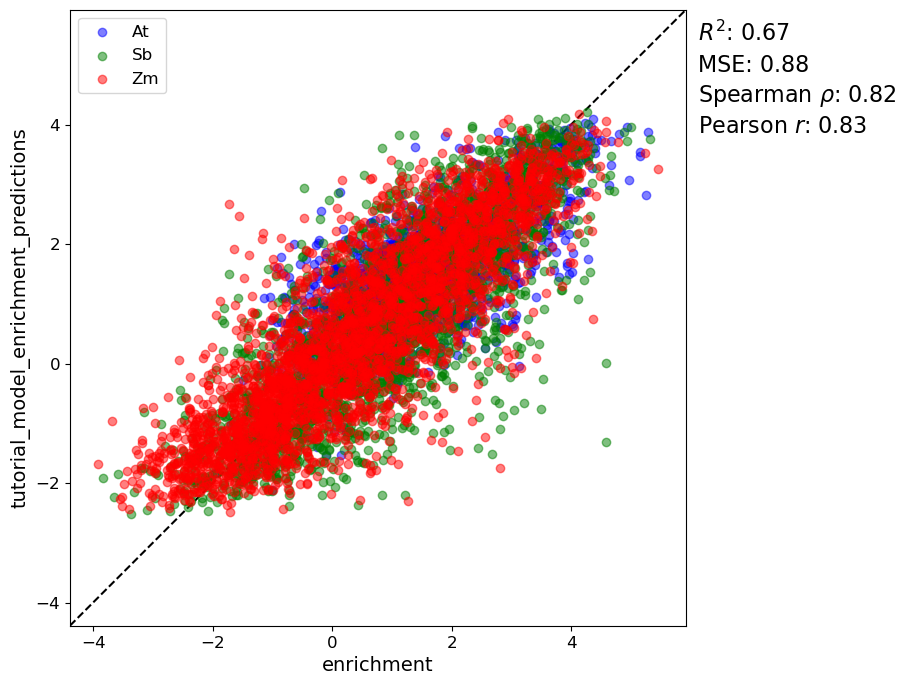

In [45]:
pl.performance_scatter(
    sdata_test, 
    target_keys="enrichment", 
    prediction_keys="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

Not too shabby. We were able to train a pretty predictive model on this dataset with just DNA sequences as input!

## Interpretation

We are also usually interested in understanding how our model is working a little bit better to make the predictions it does. This is miles away from being an exact science, but we can still utilize some clever methods to ask our model what it is seeing. This is done through the `interpret` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#interpret). 

All the functions in this module act on either `SeqData` and Models or just Models. Results from these calls can be visualized using the `pl` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#plot).

There are many options for interpreting the model's predictions, and we will again point users to the [API](https://eugene-tools.readthedocs.io/en/latest/api.html#interpret) for all the options and their arguments. We list examples for a few common ones below.

In [46]:
from eugene import interpret

### Feature attribution
We can calculate the contribution of each nucleotide to the model's predictions for a sequence by using the `interpret` module's `feature_attribution_sdata` function. We currently implement several different methods for this, including `DeepLift`, `NaiveISM`, `InputXGradient` and `GradientSHAP`.

By default, feature attributions will be added to the `uns` attribute of the `SeqData` object with the name `{interpretation method}_imps` (e.g. `DeepLift_imps`).

Here we will aply the [DeepLIFT](https://github.com/kundajelab/deeplift) method to our best model on our held-out test sequences.

In [48]:
interpret.attribute_sdata(
    best_model,
    sdata_test,
    method="DeepLift",
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:467: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  warnings.warn(


We can then visualize these importance scores using a sequence logo plot. Here we show the results on the sequences with the highest predicted activity by our model.

In [50]:
pp.make_unique_ids_sdata(sdata_test)

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

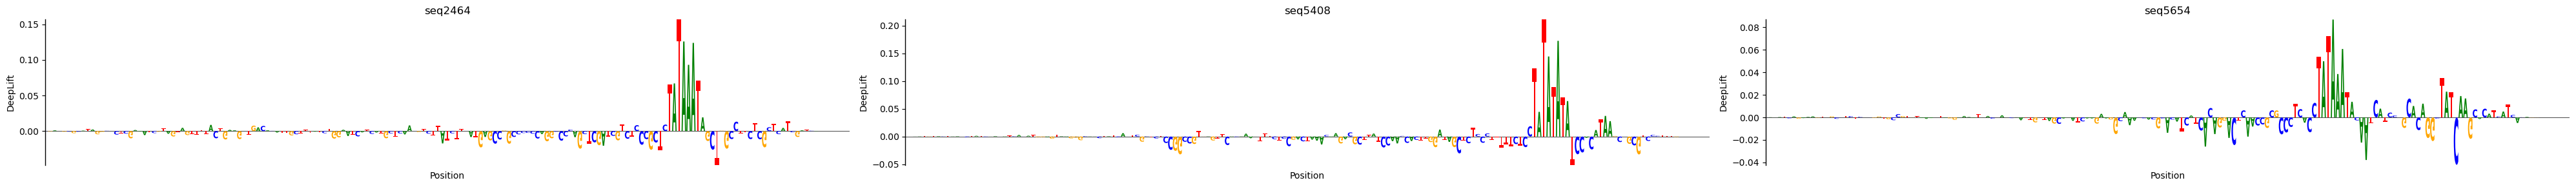

In [68]:
# Grab the top3 in terms of predictions to plot tracks for
top3 = sdata_test["tutorial_model_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:3].index
ids = sdata_test["id"].values[top3]
pl.multiseq_track(
    sdata_test,
    seq_ids=ids,
    attrs_keys = "DeepLift_attrs",
    ylabs="DeepLift",
    height=3,
    width=40,
)

### Filter Visualization 
We can get an idea for what each filter of first convoulional layer of the model is seeing by using the `interpret` module's [`generate_pfms_sdata`](https://eugene-tools.readthedocs.io/en/latest/api/eugene.interpret.generate_pfms_sdata.html?highlight=generate_pfms#eugene.interpret.generate_pfms_sdata) function. This creates a position frequency matrix for each filter in the model using sequences that highly activate that filter (can be defined in multiple ways). We often times pass the the test sequences through the model, but you can theoretically pass any sequences you want.

In [69]:
best_model

SequenceModule(
  (arch): Hybrid(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=valid)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.3, inplace=False)
        (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
        (6): ReLU()
        (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Dropout(p=0.3, inplace=False)
        (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
        (11): ReLU()
        (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (13): Dropout(p=0.3, inplace=False)
        (14): BatchNorm1d(256, 

In [71]:
interpret.generate_pfms_sdata(
    best_model,
    sdata_test,
    seq_key="ohe_seq",
    layer_name="arch.conv1d_tower.layers.1",
    kernel_size=13,
    num_filters=256,
    num_seqlets=100,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Getting activations on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

Now let's visualize these PFMs to see if we can decipher what the filters are picking up on

In [ ]:
pl.multifilter_viz(
        sdata,
        filter_nums=range(start_filter, end_filter),
        pfms_key=f"{layer_name}_pfms",
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        save=os.path.join(settings.figure_dir, name, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

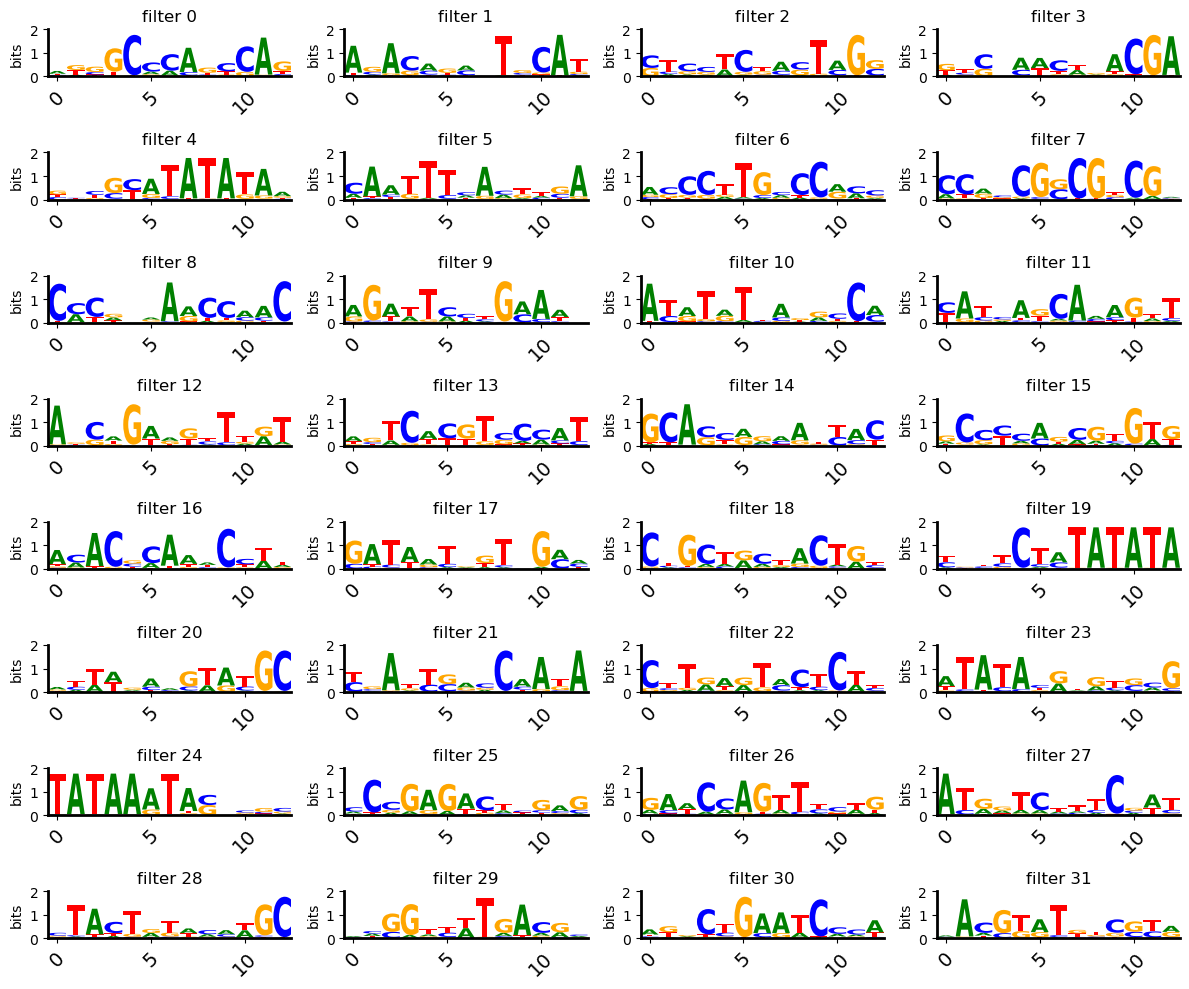

In [72]:
# We can visualize these PFMs as PWM logos
pl.multifilter_viz(
    sdata_test,
    filter_nums=range(0, 32),
    pfms_key="arch.conv1d_tower.layers.1_pfms",
    num_rows=8,
    num_cols=4,
    titles=[f"filter {i}" for i in range(0, 32)],
)

The qualitative visualization is nice, but often times we want to put some numbers behind what we are seeing. This is often done by annotating them PFMs from these filters against a database of known motifs with tools like [TomTom](https://meme-suite.org/meme/tools/tomtom). We offer a function for saving filters in an SeqData object to the MEME file format that can uploaded to the TomTom webtool.

In [75]:
sdata_test

<xarray.Dataset>
Dimensions:                                (_sequence: 7154, _length: 170,
                                            length: 170, _ohe: 4,
                                            _arch.conv1d_tower.layers.1_256_filters: 256,
                                            _arch.conv1d_tower.layers.1_13_kernel_size: 13)
Dimensions without coordinates: _sequence, _length, length, _ohe,
                                _arch.conv1d_tower.layers.1_256_filters,
                                _arch.conv1d_tower.layers.1_13_kernel_size
Data variables:
    enrichment                             (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene                                   (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq                                    (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set                                    (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp                                     (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    ohe_seq                                (_sequence, length, _ohe) uint8 0 ...
    target                                 (_sequence) float64 -0.5375 ... -1...
    tutorial_model_enrichment_predictions  (_sequence) float32 0.2628 ... -1.184
    DeepLift_attrs                         (_sequence, _ohe, length) float32 ...
    id                                     (_sequence) <U7 'seq0000' ... 'seq...
    arch.conv1d_tower.layers.1_pfms        (_arch.conv1d_tower.layers.1_256_filters, _arch.conv1d_tower.layers.1_13_kernel_size, _ohe) float32 ...

In [77]:
interpret.filters_to_meme_sdata(
    sdata_test,
    filters_key="arch.conv1d_tower.layers.1_pfms",
    axis_order=("_arch.conv1d_tower.layers.1_256_filters", "_ohe", "_arch.conv1d_tower.layers.1_13_kernel_size"),
    output_dir=os.path.join(settings.output_dir),
    filename="tutorial_model_best_model_filters.meme"
)

Output directory already exists: /cellar/users/aklie/tutorial_output
Saved pfm in MEME format as: /cellar/users/aklie/tutorial_output/tutorial_model_best_model_filters.meme


### *In silico* experimentation (ISE)
Another class of interesting methods are those that use the model as an *in silico* oracle to make predictions on computer generated sequences. There are no shortage of potential ideas of what sequence to feed the model, but here we will show a few examples of commonly used *in silico* approaches, in silico evolution and feature implantation

#### *In silico* evolution
*In silico* evolution involves taking a trained model and using it to find the mutation that increases the predicted score of the sequence the most. Iterating this over multiple rounds with a well trained model usually leads to some interesting sequence evolutions and can be done within EUGENe!

It can take a little while to evolve many sequences at once (thank you naive ISM), so we will start with just a single sequence.

In [89]:
import seqpro as sp
import xarray as xr

In [97]:
random_ohe_seq = sp.ohe(sp.random_seqs((2, 170), sp.alphabets.DNA), sp.alphabets.DNA).swapaxes(1, 2)

In [98]:
# Create an SeqData object so its compatible with the function
sdata_ise = xr.Dataset({"ohe_seq": (("_sequence", "_ohe", "length"), random_ohe_seq)})

In [99]:
sdata_ise

<xarray.Dataset>
Dimensions:  (_sequence: 2, _ohe: 4, length: 170)
Dimensions without coordinates: _sequence, _ohe, length
Data variables:
    ohe_seq  (_sequence, _ohe, length) uint8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 1 1 0

In [100]:
# Evolve this sequence for ten rounds
interpret.evolve_seqs_sdata(
    model=best_model,
    sdata=sdata_ise,
    rounds=10
)

Evolving seqs:   0%|          | 0/2 [00:00<?, ?it/s]

In [113]:
# Get all the vars that start with "evolved"
evolved_vars = ["original_score"] + [var for var in sdata_ise.data_vars if var.startswith("evolved") and var.endswith("score")]

In [114]:
# Check the predicted value at each round of evolution
sdata_ise[evolved_vars].to_dataframe()

,original_score,evolved_1_score,evolved_2_score,evolved_3_score,evolved_4_score,evolved_5_score,evolved_6_score,evolved_7_score,evolved_8_score,evolved_9_score,evolved_10_score
_sequence,,,,,,,,,,,
0,0.034955,1.920021,3.056425,3.244608,3.329983,3.406659,3.473161,3.532316,3.577503,3.615668,3.652455
1,-0.274135,2.953411,3.231250,3.356227,3.446260,3.517886,3.585062,3.633615,3.673745,3.709147,3.745637


#### *In silico* implantation
*In silico* implantation involves taking a trained model and using it to find the mutation that increases the predicted score of the sequence the most. Iterating this over multiple rounds with a well trained model usually leads to some interesting sequence evolutions and can be done within EUGENe!

To do this, we need a feature to implant! As an example, we will use the TATA box motif that can be downlaoded and read from a MEME file of core promoter elements found [here](https://github.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/blob/main/data/misc/CPEs.meme).

In [115]:
import motifdata as md

In [116]:
# Read in the motif
motif_set = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
motif = motif_set["TATA"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus
consensus_ohe = sp.ohe(consensus, alphabet=sp.alphabets.DNA)

FileNotFoundError: [Errno 2] No such file or directory: '/cellar/users/aklie/tutorial_dataset/CPEs.meme'

In [120]:
# Make sure you downloaded the MEME file to your dataset_dir
# We can load it and pull out the PFM and other info about the motif
meme = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus
consensus_ohe = sp.ohe(consensus, alphabet=sp.alphabets.DNA)
feat_name, pfm, consensus

('TATA',
 array([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.199 , 0.2455],
        [0.249 , 0.303 , 0.197 , 0.251 ],
        [0.1235, 0.655 , 0.0755, 0.1455],
        [0.01  , 0.002 , 0.002 , 0.986 ],
        [0.968 , 0.    , 0.    , 0.032 ],
        [0.002 , 0.014 , 0.006 , 0.978 ],
        [0.992 , 0.    , 0.002 , 0.006 ],
        [0.653 , 0.012 , 0.002 , 0.333 ],
        [0.974 , 0.    , 0.008 , 0.018 ],
        [0.341 , 0.028 , 0.036 , 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.432 , 0.3165, 0.1255],
        [0.291 , 0.418 , 0.175 , 0.1155],
        [0.263 , 0.3445, 0.1755, 0.2175],
        [0.307 , 0.3085, 0.2365, 0.1475]]),
 'CCCCTATAAATACCCC')

Now that we have a feature, we can implant it at every possible position of the input sequence and see what that does to model predictions.

In [130]:
pp.make_unique_ids_sdata(sdata_ise, id_var="name")

In [131]:
# This is the EUGENe function that does exactly that!
interpret.positional_gia_sdata(
    model=best_model, 
    sdata=sdata_ise, 
    feature=consensus_ohe,
    id_key="name",
    store_key=f"slide_{feat_name}",
    encoding="onehot"
)

Implanting feature in all seqs of sdata:   0%|          | 0/2 [00:00<?, ?it/s]

Next we can visualize the results as a line plot using a custom function from the `plot` module.

In [132]:
sdata_ise["slide_TATA"].values

array([[ 3.142783  ,  3.140166  ,  3.1347156 ,  3.1500568 ,  3.3393822 ,
         3.3635278 ,  3.3678603 ,  3.362761  ,  3.3617668 ,  3.3677757 ,
         3.368305  ,  3.3698611 ,  3.4217646 ,  3.430594  ,  3.4306908 ,
         3.433976  ,  3.4173102 ,  3.403779  ,  3.3873098 ,  3.3815417 ,
         3.40512   ,  3.4084373 ,  3.4170353 ,  3.4196079 ,  3.4047766 ,
         3.3942335 ,  3.395827  ,  3.3839028 ,  3.3828912 ,  3.4052525 ,
         3.4086823 ,  3.416938  ,  3.4038656 ,  3.3908386 ,  3.388823  ,
         3.376809  ,  3.361227  ,  3.3269422 ,  3.3039937 ,  3.3724334 ,
         3.3838325 ,  3.3720286 ,  3.347179  ,  3.3342717 ,  3.2552638 ,
         3.140913  ,  3.102506  ,  3.138842  ,  3.1866734 ,  3.3048232 ,
         3.309213  ,  3.325244  ,  3.1085742 ,  3.1531854 ,  3.1974485 ,
         3.2852788 ,  3.3047128 ,  3.328739  ,  3.3051543 ,  3.2815185 ,
         3.028612  ,  3.0343046 ,  3.008814  ,  3.102164  ,  3.1905527 ,
         3.207764  ,  3.1011329 ,  2.9073708 ,  2.7

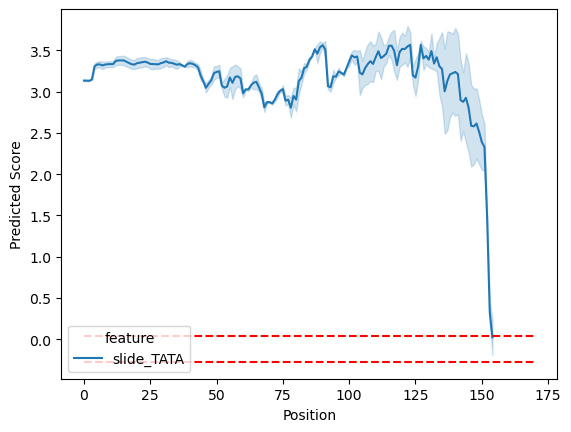

In [135]:
ax = pl.positional_gia_plot(
    sdata_ise,
    keys=[f"slide_{feat_name}"],
    id_key="name",
    return_axes=True
)
ax.hlines(sdata_ise["original_score"].values[0], 0, 170, linestyle="--", color="red")
ax.hlines(sdata_ise["original_score"].values[1], 0, 170, linestyle="--", color="red");

## Wrapping up
Like most of EUGENe, this tutorial is very much a work in progress. Don't hesitate to raise a GitHub issue if you run into any errors or if anything is overly confusing!

We will also be adding new tutorials on [the GitHub very soon!](https://github.com/cartercompbio/EUGENe/tree/main/tutorials)

---